# Import and Inputs

In [ ]:
%load_ext autoreload
%autoreload 2
import re
import os
import pandas as pd
from os import makedirs

In [ ]:
# Input target
target_lemma = 'air'
target_pos = 'N'
keyword_string = f'{target_lemma}\t{target_pos}' # Or you can use the full POS for precision (e.g., {target_lemma}\tNOUN)

# Periods, corpus path, pattern of the file names and regex patterns of the CONLLU file
period = '1750-1819'
corpus_path = '/home/volt/bach/pilot_data/RSC/1750-1819_che_half_decades'
fname_pattern = re.compile(
    r'Royal_Society_Corpus_open_v6\.0_text_(?P<id>\d+)_(?P<year>\d+)\.txt$'
)
corpus_pattern = re.compile(
    r'([^\t]+)\t'      # word form
    r'([^\t]+)\t'      # lemma
    r'([^\t])[^\t]*\t' # POS (UPOS or XPOS)
    r'([^\t]+)\t'      # ID
    r'([^\t]+)\t'      # HEAD
    r'([^\t]+)'        # DEPREL
)

# Input and output folders
input_SCD = f'/home/volt/bach/SynFlow/input/SCD/{target_lemma}-{target_pos}-{period}'
output_folder = f'/home/volt/bach/SynFlow/output/{target_lemma}-{target_pos}-{period}'
output_explorer = f'{output_folder}/Explorer'
output_embedding = f'{output_folder}/Embedding'

makedirs(output_explorer, exist_ok=True)
makedirs(output_embedding, exist_ok=True)
makedirs(input_SCD, exist_ok=True)

# The path to the slot count JSON file
slot_json_path = "/home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spaths.json"

# Slot exist table

In [ ]:
from SynFlow.SCD import slot_exist_table

slot_exist_table_df = slot_exist_table(slot_json_path)
slot_exist_table_df

# Slot frequency change

In [15]:
# Token counts for normalisation
from SynFlow.SCD import count_keyword_tokens_by_period
token_counts = count_keyword_tokens_by_period(corpus_path, keyword_string,
                                              fname_pattern=fname_pattern)
print(token_counts)

{'1750': 241, '1755': 327, '1760': 124, '1765': 977, '1770': 1578, '1775': 1773, '1780': 2928, '1785': 2430, '1790': 1498, '1795': 340, '1800': 654, '1805': 373, '1810': 279, '1815': 451}


In [24]:
from SynFlow.SCD import plot_freq_top_union_slots_by_period
slot_json_path = "/home/volt/bach/SynFlow/output/air-N-1750-1819/Explorer/air_N_spaths.json"

plot_freq_top_union_slots_by_period(
    json_path=slot_json_path,
    top_n=10,
    normalized=False,
    relative=True,
    token_counts=token_counts,
)

In [ ]:
# Haven't used this yet
def slot_change_scores(json_path, token_counts):
    '''
    Return the ranking of the top changing slots across periods

    Parameters:
        json_path (str): Path to JSON with slot counts per period.
        token_counts (dict): {period: token count} for normalisation
    
    Returns:
        dict: {slot: change_score}
    '''
    # Read json file
    with open(json_path, "r") as f:
        data = json.load(f)

    # Load into DataFrame
    df = pd.DataFrame.from_dict(data, orient="index").fillna(0).astype(float)

    # # Normalised by the number of token counts in that period
    if token_counts is None:
        raise ValueError("token_counts must be provided when normalized=True")
    token_counts_str = {str(k).replace("_", "-"): v for k, v in token_counts.items()}

    missing = set(df.index) - set(token_counts_str.keys())
    if missing:
        raise ValueError(f"Missing document counts for: {missing}")
    for period in df.index:
        df.loc[period] /= token_counts_str[period]

    # Take row n and subtract row n-1 and convert into positive
    df_diff = df.diff(axis=0).fillna(0).abs()

    # Culmulative Change
    # Sum over all rows and sort
    df_diff_sum = df_diff.sum(axis=0).sort_values(ascending=False)

    # Max single-period change
    max_change = df_diff.max(axis=0).sort_values(ascending=False)

    # Compute range (max - min) over all periods
    df_range = (df.max(axis=0) - df.min(axis=0)).sort_values(ascending=False)

    # Standard deviation
    std_change = df.std(axis=0).sort_values(ascending=False)

    return df_diff_sum, max_change, df_range, std_change

df_diff_sum, max_change, df_range, std_change = slot_change_scores(json_path=slot_json_path, token_counts=token_counts)
print('df_diff_sum:', df_diff_sum)
print('-' * 100)
print('max_change:', max_change)
print('-' * 100)
print('df_range', df_range)
print('-' * 100)
print('std_change', std_change)

# JSD based on the distributions of slots


=== Shift to period 1755 ===
Jensen-Shannon Divergence: 0.0137
Top shifted items:
  in_pa_nmod: 0.0031
  de_chi_punct: 0.0030
  de_chi_nmod: 0.0024
  de_chi_det: 0.0011
  in_chi_conj: 0.0009
  in_chi_case: 0.0008
  de_chi_acl:relcl: 0.0008
  in_chi_amod: 0.0005
  in_pa_compound: 0.0005
  de_pa_nsubj:pass: 0.0002

=== Shift to period 1760 ===
Jensen-Shannon Divergence: 0.0135
Top shifted items:
  de_pa_nsubj:pass: 0.0034
  de_pa_compound: 0.0033
  in_chi_det: 0.0024
  de_chi_amod: 0.0011
  in_chi_acl:relcl: 0.0010
  in_pa_nsubj: 0.0008
  de_pa_obj: 0.0004
  in_chi_acl: 0.0003
  in_chi_nmod: 0.0002
  in_chi_conj: 0.0002

=== Shift to period 1765 ===
Jensen-Shannon Divergence: 0.0366
Top shifted items:
  in_chi_amod: 0.0145
  de_chi_det: 0.0079
  in_pa_nsubj:pass: 0.0046
  in_pa_obj: 0.0037
  in_chi_acl: 0.0020
  de_pa_compound: 0.0008
  de_chi_conj: 0.0007
  de_chi_cc: 0.0007
  de_pa_conj: 0.0007
  de_pa_obl: 0.0003

=== Shift to period 1770 ===
Jensen-Shannon Divergence: 0.0075
Top shi

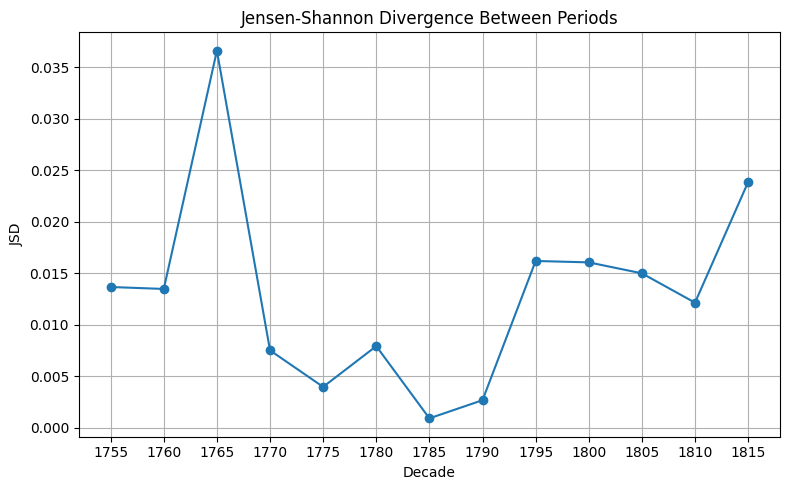

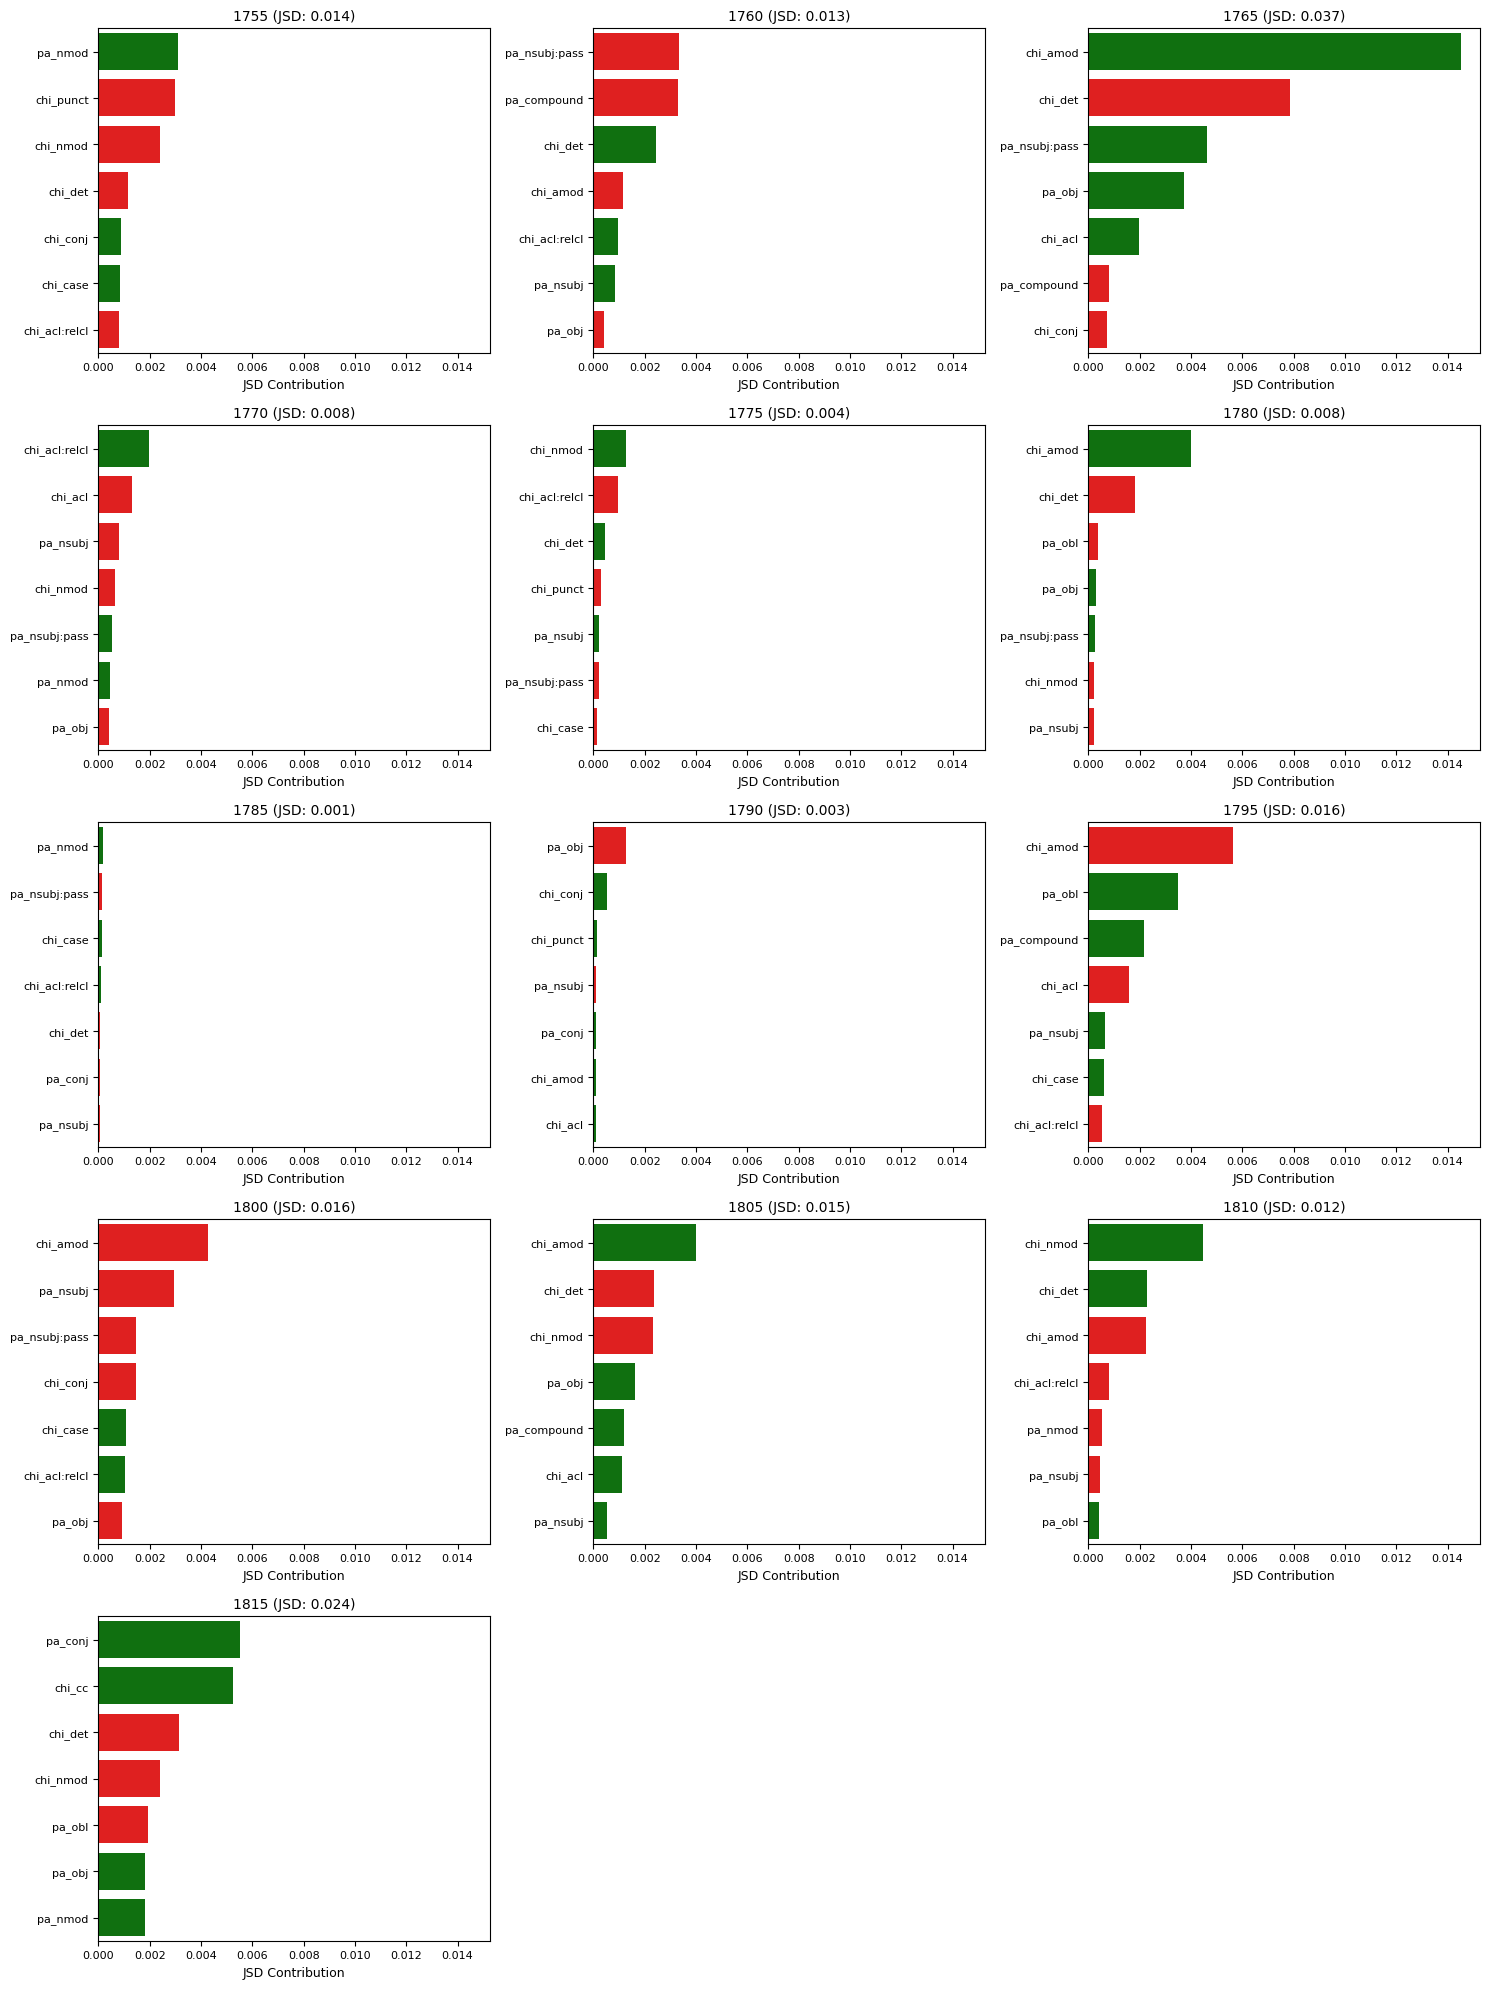

In [14]:
from SynFlow.SCD import slots_jsd_by_period, print_jsd_by_period, plot_jsd_by_period, plot_items_jsd_by_period
slots_js_results = slots_jsd_by_period(
    json_path=slot_json_path,
    top_n=10,
    min_count=0
)

print_jsd_by_period(slots_js_results)
plot_jsd_by_period(slots_js_results)
plot_items_jsd_by_period(slots_js_results, top_n=7, cols=3)

# Get the slot fillers df of all slots

In [ ]:
# Calculate relative frequencies of all slots by period
from SynFlow.SCD import freq_all_slots_by_period_relative
rel_freq_all_slots_by_period_df = freq_all_slots_by_period_relative(json_path=slot_json_path)
rel_freq_all_slots_by_period_df

In [ ]:
# Get the labels of all slots to build a slot filler df
all_slots = ''.join(f'[{s}]' for s in rel_freq_all_slots_by_period_df['Slot Type'].unique())
all_slots

# Building a slot filler df
from SynFlow.Explorer import build_sfiller_df

df_slots = build_sfiller_df(
    corpus_folder=corpus_path,
    template=all_slots, 
    target_lemma=target_lemma,
    target_pos=target_pos,
    pattern=corpus_pattern,
    # freq_path='/home/volt/bach/pilot_data/RSC/lemma_pos_init_freq.txt', # Be sure that the freq_path matches that of the filter format
    # freq_min=1,
    # freq_max=100_000_000,
    filtered_pos=[],
    filler_format='lemma/pos', # lemma/deprel or 'lemma/pos'
    output_folder= output_embedding
)

In [ ]:
# Note that it is NECESSARY to manually check and correct for the spellings in the CSV file
from SynFlow.Explorer import replace_in_sfiller_df_column

replace_column = 'chi_amod'
replacements = {
    "dephlogisticate/V": "dephlogisticated/A",
    "phlogisticate/V": "phlogisticated/A",
    'plllogisticate/V': 'phlogisticated/A',
    'deplllogisticate/V': 'dephlogisticated/A',
    'gisticate/V': 'phlogisticated/A',
    'Open/A': 'open/A',
    'atmospheric/A': 'atmospherical/A',
}

all_sfillers_csv_path = '/home/volt/bach/SynFlow/output/air-N-1750-1819/Embedding/air_samples_sfillerdf_all.csv'

replace_in_sfiller_df_column(all_sfillers_csv_path, replace_column, replacements)

# Calculate weighted slot divergences of all slots

In [ ]:
from SynFlow.SCD import total_divergence_slots

total_divergence_df = total_divergence_slots(slot_json_path=slot_json_path,
                                            all_sfillers_csv_path=all_sfillers_csv_path,
                                            min_freq=1)
total_divergence_df

In [ ]:
import numpy as np
import pandas as pd

def elbow_by_line(df, value_col="Weighted Total Divergence", name_col="Slot Type"):
    # Chỉ giữ các row có value > 0
    d = df[[name_col, value_col]].dropna().copy()
    d = d[d[value_col] > 0]
    d = d.sort_values(value_col, ascending=False).reset_index(drop=True)

    if d.empty:
        return d.iloc[:0], 0.0, 0

    s = d[value_col].to_numpy(float)
    n = len(s)
    x = np.arange(1, n + 1) / n
    y = s / s[0]  # normalize to 1 at top

    # line qua (x1,y1) và (xN,yN)
    x1, y1, xN, yN = x[0], 1.0, x[-1], y[-1]
    A = yN - y1
    B = x1 - xN
    C = xN * y1 - x1 * yN

    # khoảng cách vuông góc
    dist = np.abs(A * x + B * y + C) / np.sqrt(A * A + B * B)
    elbow_idx = int(np.argmax(dist))  # 0-based
    cutoff = s[elbow_idx]

    return d.iloc[:elbow_idx + 1].copy(), float(cutoff), elbow_idx + 1


selected, cutoff, K = elbow_by_line(total_divergence_df)
selected

In [ ]:
selected, cutoff, K = elbow_by_line(total_divergence_df) # Min
selected

In [ ]:
selected, cutoff, K = elbow_by_line(total_divergence_df) # Max
selected

In [ ]:
import numpy as np
import pandas as pd

def pareto_cutoff(df, value_col="Weighted Total Divergence", name_col="Slot Type", threshold=0.8):
    """
    Chọn các slot theo nguyên tắc Pareto: 
    lấy top k sao cho tổng value >= threshold * tổng tất cả value.

    Parameters
    ----------
    df : DataFrame có cột name_col và value_col
    value_col : str, tên cột chứa giá trị
    name_col : str, tên cột chứa slot name
    threshold : float trong (0,1], mặc định 0.8

    Returns
    -------
    selected_df : DataFrame (các slot được chọn)
    cutoff : float, giá trị tại ngưỡng cutoff
    k : int, số slot được chọn
    """
    d = df[[name_col, value_col]].dropna().copy()
    d = d[d[value_col] > 0]
    d = d.sort_values(value_col, ascending=False).reset_index(drop=True)

    if d.empty:
        return d.iloc[:0], 0.0, 0

    total = d[value_col].sum()
    cum = d[value_col].cumsum()
    k = int((cum >= threshold * total).idxmax()) + 1
    cutoff = d.loc[k-1, value_col]

    return d.iloc[:k].copy(), float(cutoff), k

pareto_cutoff(total_divergence_df)